In [1]:
!pip install -q ultralytics opencv-python matplotlib pillow

In [2]:
from ultralytics import YOLO
print("YOLO imported successfully!")

YOLO imported successfully!


In [3]:
import cv2
import os
import numpy as np
from glob import glob


In [6]:
def preprocess_image(img_path, save_path, size=(640, 640)):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read {img_path}")
        return
    
    # Resize
    img = cv2.resize(img, size)
    
    # Lighting normalization (LAB)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    # Mild denoising
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, img)


In [7]:
BASE_DIR = "damagedetection.v1-damagedetector.yolov8"

train_imgs = glob(f"{BASE_DIR}/train/images/*")
val_imgs   = glob(f"{BASE_DIR}/valid/images/*")

print(f"Train images found: {len(train_imgs)}")
print(f"Val images found: {len(val_imgs)}")

for img_path in train_imgs:
    filename = os.path.basename(img_path)
    save_path = f"{BASE_DIR}/preprocessed/train/images/{filename}"
    preprocess_image(img_path, save_path)

for img_path in val_imgs:
    filename = os.path.basename(img_path)
    save_path = f"{BASE_DIR}/preprocessed/valid/images/{filename}"
    preprocess_image(img_path, save_path)

print("Preprocessing completed!")


Train images found: 107
Val images found: 21
Preprocessing completed!


In [9]:
import shutil

shutil.copytree(
    f"{BASE_DIR}/train/labels",
    f"{BASE_DIR}/preprocessed/train/labels",
    dirs_exist_ok=True
)

shutil.copytree(
    f"{BASE_DIR}/valid/labels",
    f"{BASE_DIR}/preprocessed/valid/labels",
    dirs_exist_ok=True
)

print("Labels copied!")


Labels copied!


In [10]:
BASE_DIR = "damagedetection.v1-damagedetector.yolov8"

yaml_content = f"""
train: {BASE_DIR}/preprocessed/train/images
val: {BASE_DIR}/preprocessed/valid/images
nc: 5
names: ['broken_parts', 'cracks', 'dent', 'paint_damage', 'scratch']
"""

with open(f"{BASE_DIR}/data_preprocessed.yaml", "w") as f:
    f.write(yaml_content)

print("data_preprocessed.yaml created successfully!")


data_preprocessed.yaml created successfully!


In [11]:
from ultralytics import YOLO
import os

BASE_DIR = "damagedetection.v1-damagedetector.yolov8"
DATA_YAML = f"{BASE_DIR}/data_preprocessed.yaml"

print("Using YAML:", DATA_YAML)


Using YAML: damagedetection.v1-damagedetector.yolov8/data_preprocessed.yaml


In [13]:
model = YOLO("yolov8n.pt")  # nano model for CPU

results = model.train(
    data=DATA_YAML,
    epochs=20,       # if slow, set 10
    imgsz=640,
    batch=8,
    device="cpu",    # force CPU to avoid CUDA issues
    project="runs",
    name="damage_yolov8_preprocessed"
)


Ultralytics 8.4.14  Python-3.10.19 torch-2.10.0+cpu CPU (12th Gen Intel Core i5-1230U)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=damagedetection.v1-damagedetector.yolov8/data_preprocessed.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=damage_yolov8_preprocessed2, nbs=64, nms=False, opset=None, optimize=False, op

In [19]:
import glob

paths = glob.glob("runs/detect/**/weights/best.pt", recursive=True)
paths


['runs/detect\\runs\\damage_yolov8_preprocessed2\\weights\\best.pt']

In [40]:
from ultralytics import YOLO

BEST_MODEL_PATH = paths[0]
model = YOLO(BEST_MODEL_PATH)
print("Loaded model from:", BEST_MODEL_PATH)


Loaded model from: runs/detect\runs\damage_yolov8_preprocessed2\weights\best.pt


In [49]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-15-231039_png.rf.b457108708fe3992a324486e7632ce8e.jpg: 640x640 2 scratchs, 203.9ms
Speed: 42.8ms preprocess, 203.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


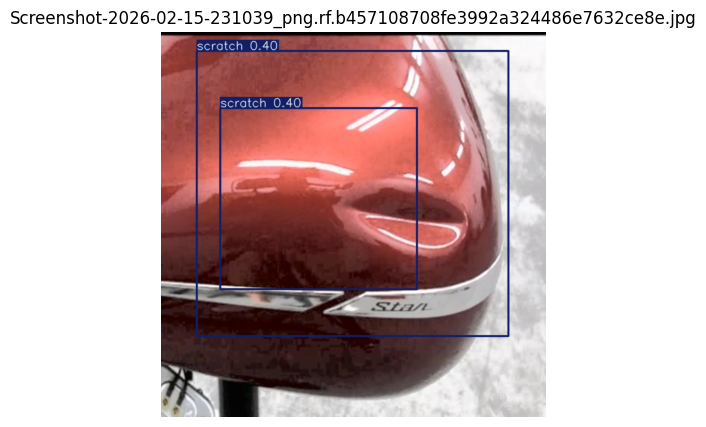


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-15-232048_png.rf.b5fb455e8d005b6b84b7007b681d0117.jpg: 640x640 (no detections), 208.3ms
Speed: 5.5ms preprocess, 208.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


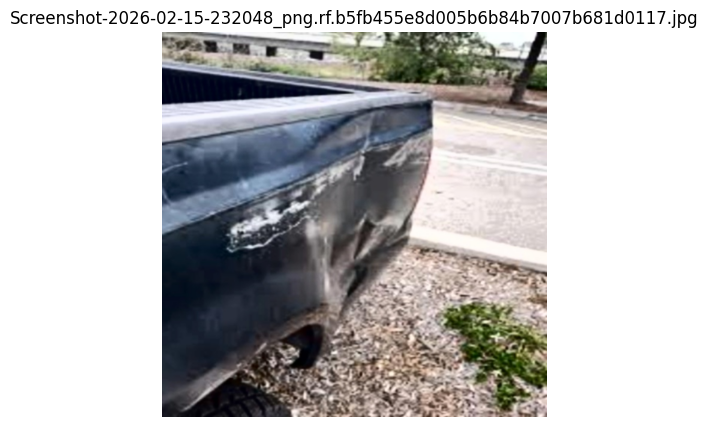


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-15-232152_png.rf.f4de48f3d2725c2fdb79de4c9d849eef.jpg: 640x640 1 broken_parts, 204.9ms
Speed: 5.5ms preprocess, 204.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


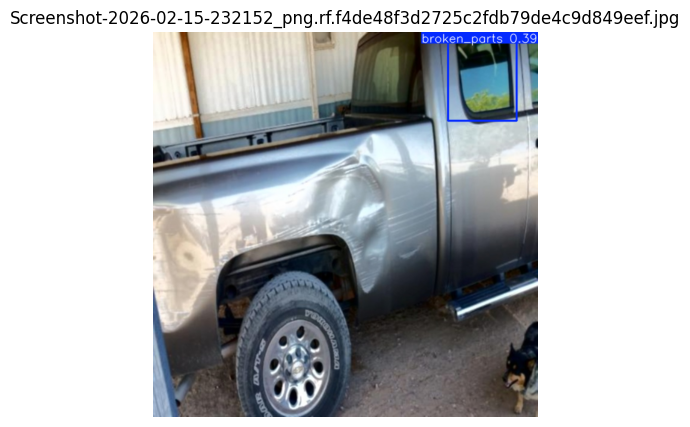


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-15-232228_png.rf.19c4b604cd30313d4af23f17ac0c8aa7.jpg: 640x640 (no detections), 174.5ms
Speed: 5.8ms preprocess, 174.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


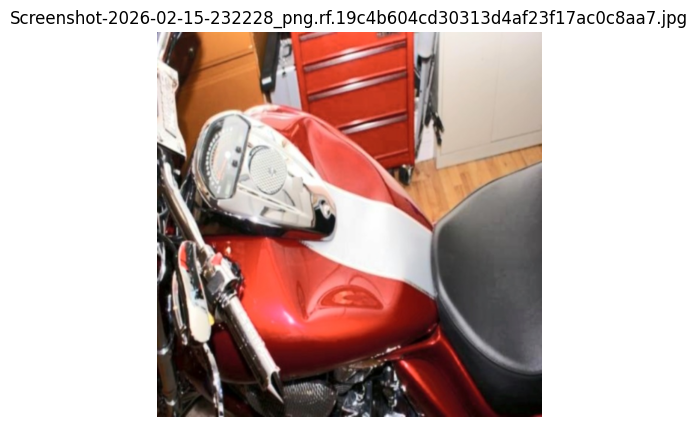


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-15-233253_png.rf.1ad31cfc32c103b6598bf100d648a53f.jpg: 640x640 2 scratchs, 188.2ms
Speed: 5.7ms preprocess, 188.2ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


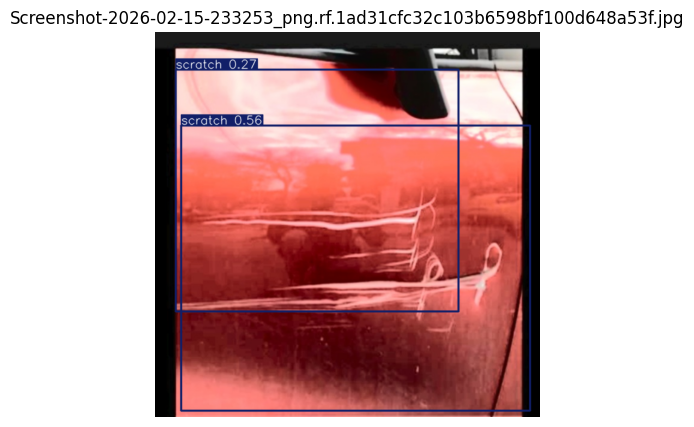


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-15-233444_png.rf.e2d310a9d0e1c1eafb98e83c0d4c102c.jpg: 640x640 1 broken_parts, 190.2ms
Speed: 4.7ms preprocess, 190.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


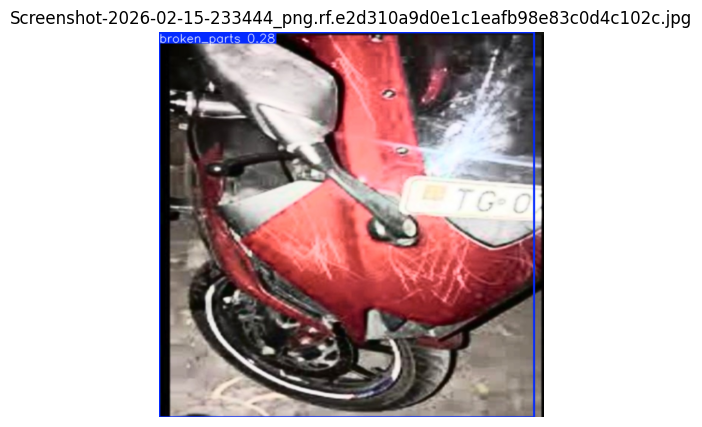


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-000730_png.rf.a262e6b18612d2630952cd87001f161e.jpg: 640x640 1 broken_parts, 2 crackss, 192.6ms
Speed: 6.9ms preprocess, 192.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


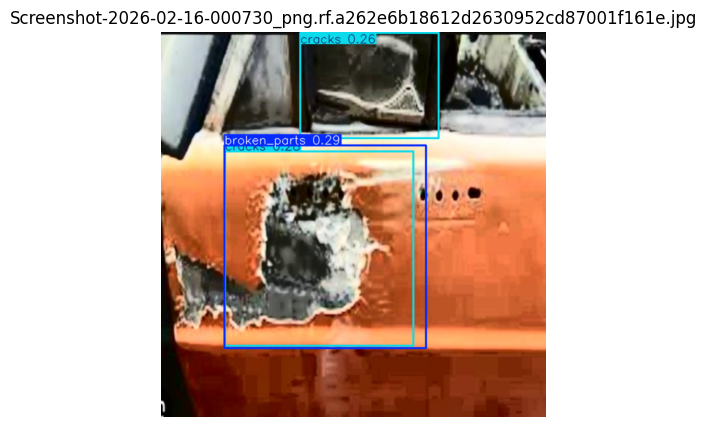


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001015_png.rf.3146e5b89b85adccf6cd24935957998a.jpg: 640x640 (no detections), 225.8ms
Speed: 7.1ms preprocess, 225.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


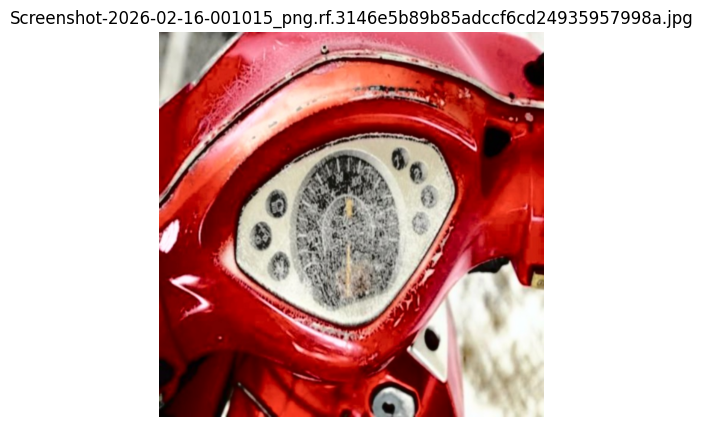


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001217_png.rf.37b5383a0c70bf83d4581f99a1ed83b4.jpg: 640x640 1 paint_damage, 192.1ms
Speed: 6.1ms preprocess, 192.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


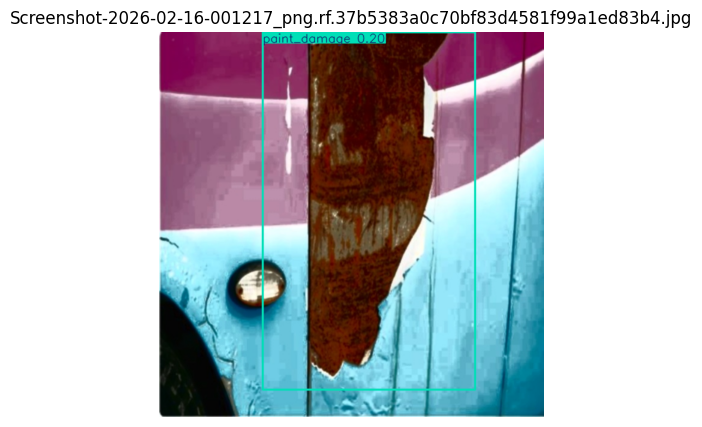


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001432_png.rf.27403c8dbe6cf4a130b3decacb3979da.jpg: 640x640 1 cracks, 232.8ms
Speed: 9.5ms preprocess, 232.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


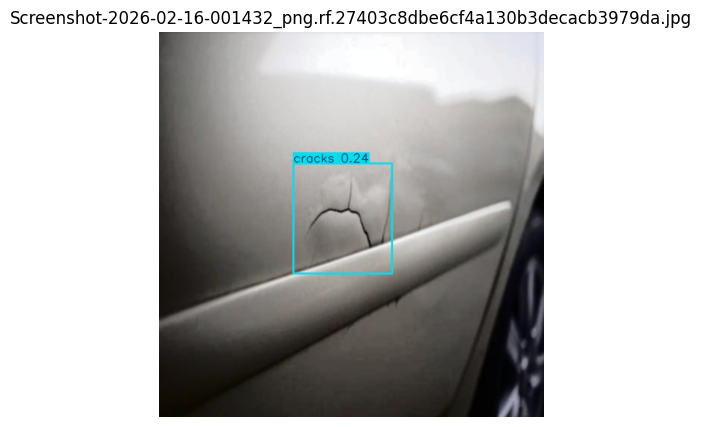


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001507_png.rf.bad4b76d14eb365bc6ff4e1a13319723.jpg: 640x640 1 broken_parts, 218.9ms
Speed: 16.6ms preprocess, 218.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


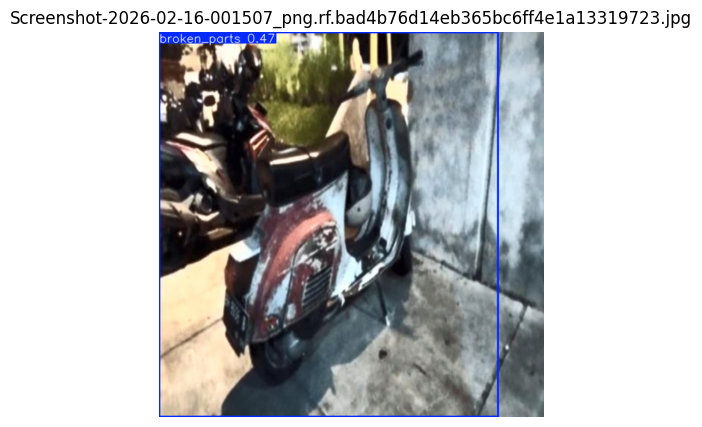


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001638_png.rf.5837e039e15e32d2f2e91ef841507652.jpg: 640x640 (no detections), 205.4ms
Speed: 7.2ms preprocess, 205.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


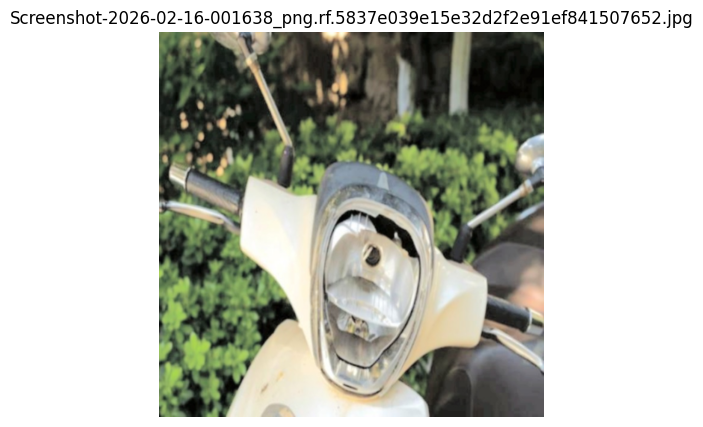


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001837_png.rf.f29a44bb4a6f55d1b792df825d867c6c.jpg: 640x640 (no detections), 205.3ms
Speed: 5.2ms preprocess, 205.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


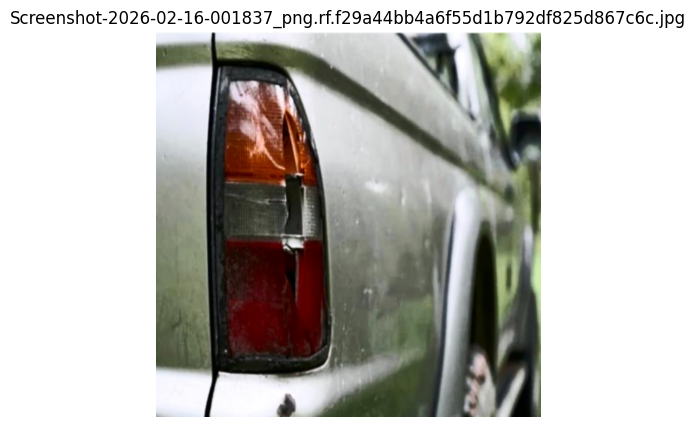


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-005603_png.rf.2a1fdac1b620eeb098c07e6df50c12cb.jpg: 640x640 2 crackss, 204.6ms
Speed: 5.8ms preprocess, 204.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


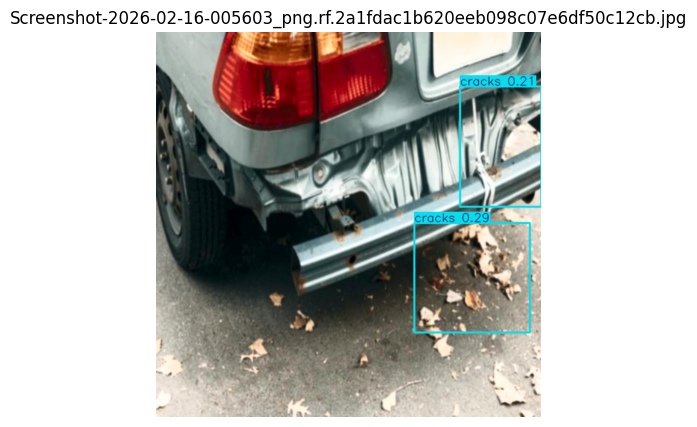


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-005946_png.rf.139decb47e4705325e179b9e3e1a52e0.jpg: 640x640 1 scratch, 250.8ms
Speed: 6.5ms preprocess, 250.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


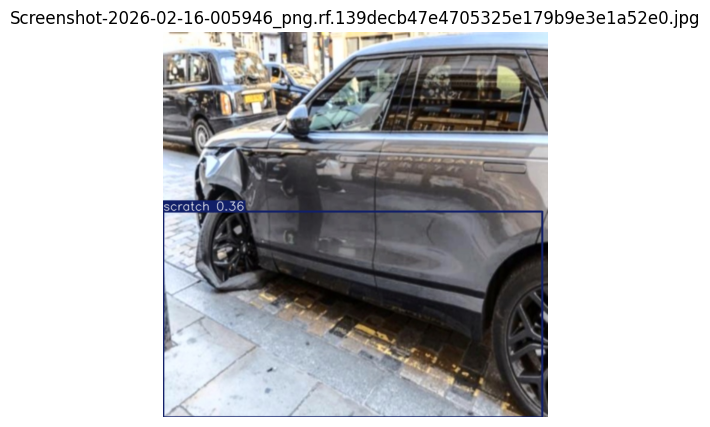


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-010308_png.rf.14dd75ec4d9665ac88616e9b7de12917.jpg: 640x640 1 broken_parts, 226.4ms
Speed: 6.6ms preprocess, 226.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


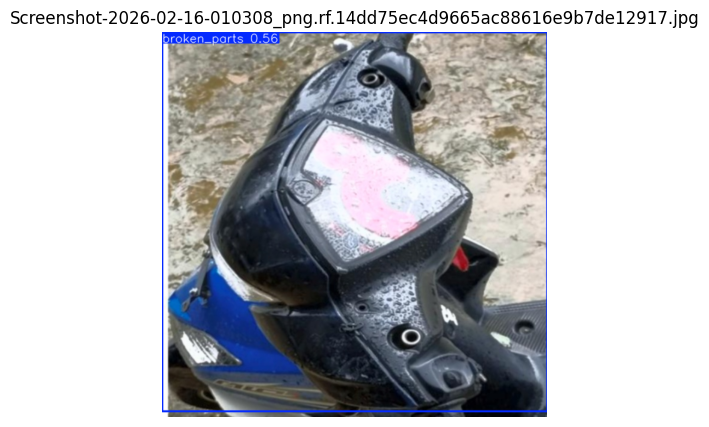


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-010320_png.rf.5ff51e74bfccc014809caee7ffb173ee.jpg: 640x640 2 paint_damages, 254.7ms
Speed: 6.1ms preprocess, 254.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


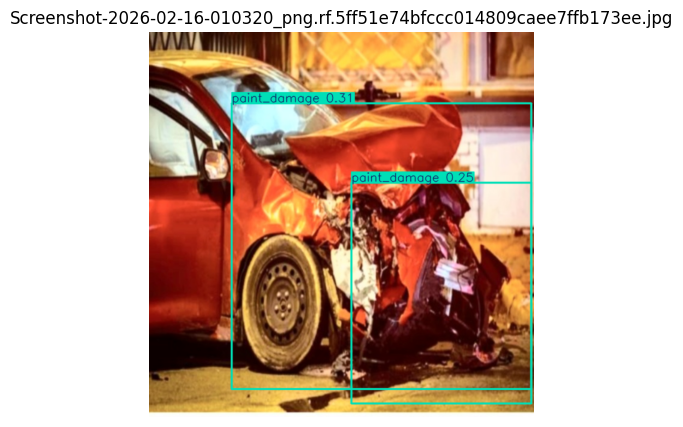


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-010354_png.rf.567be7d62b416195ab046beffce9b8e0.jpg: 640x640 1 broken_parts, 1 paint_damage, 913.2ms
Speed: 7.5ms preprocess, 913.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


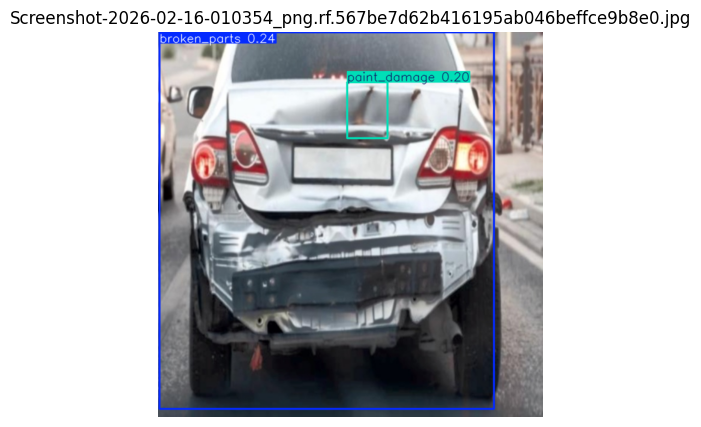


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-010502_png.rf.df9dcbf13b6456744c33acd518224420.jpg: 640x640 (no detections), 264.4ms
Speed: 9.0ms preprocess, 264.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


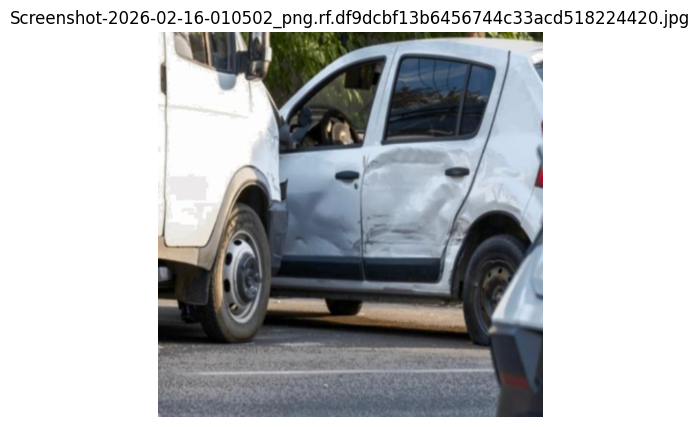


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-011119_png.rf.c0078acb1893f698ae0b0370618eba2a.jpg: 640x640 1 broken_parts, 239.0ms
Speed: 7.1ms preprocess, 239.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


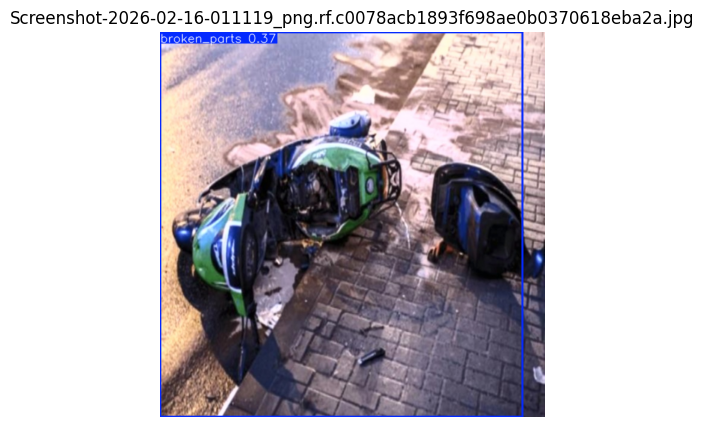


image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-011216_png.rf.643599a60c38ba904d9f408378a11167.jpg: 640x640 (no detections), 237.1ms
Speed: 7.0ms preprocess, 237.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


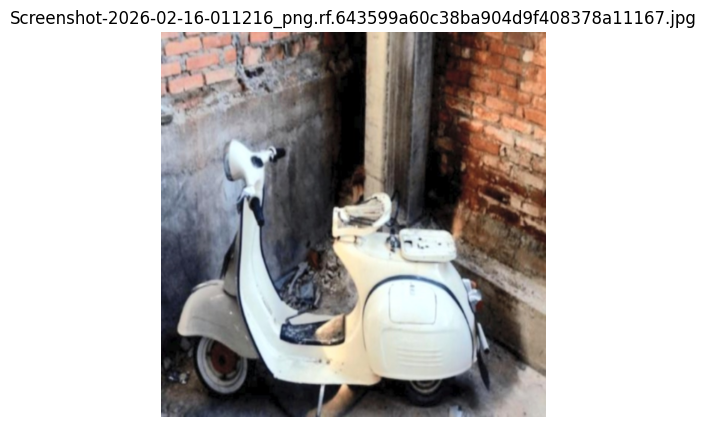

In [67]:
import os
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "damagedetection.v1-damagedetector.yolov8"
img_dir = f"{BASE_DIR}/preprocessed/valid/images"

image_files = os.listdir(img_dir)

for fname in image_files:
    test_img = os.path.join(img_dir, fname)
    
    # Run inference
    res = model(test_img, conf=0.2, iou=0.5)
    
    # Plot boxes on image
    annotated = res[0].plot()
    
    # Convert BGR -> RGB for correct colors
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    
    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(annotated_rgb)
    plt.title(fname)
    plt.axis("off")
    plt.show()


In [68]:
import os

BASE_DIR = "damagedetection.v1-damagedetector.yolov8"
img_dir = f"{BASE_DIR}/preprocessed/valid/images"

image_files = sorted(os.listdir(img_dir))

test_img_9 = os.path.join(img_dir, image_files[8])   # 9th image (0-indexed)
test_img_10 = os.path.join(img_dir, image_files[9])  # 10th image

test_img_9, test_img_10

def generate_final_report_for_image(image_path, vehicle_type="4W"):
    res = model(image_path, conf=0.3, iou=0.5)
    
    img = cv2.imread(image_path)
    h, w, _ = img.shape
    
    final_report = []
    
    for box in res[0].boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        damage_type = CLASS_NAMES[cls_id]
        severity = estimate_severity(x1, y1, x2, y2, w, h)
        category = cosmetic_or_functional(damage_type)

        final_report.append({
            "image": os.path.basename(image_path),
            "vehicle_type": vehicle_type,
            "damage_type": damage_type,
            "location_bbox": [x1, y1, x2, y2],
            "severity": severity,
            "category": category,
            "confidence": round(conf, 2)
        })
    
    return final_report, res



In [69]:
report_9, res_9 = generate_final_report_for_image(test_img_9, vehicle_type="4W")
report_10, res_10 = generate_final_report_for_image(test_img_10, vehicle_type="4W")

print("Final Report – Image 9:")
report_9

print("\nFinal Report – Image 10:")
report_10



image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001217_png.rf.37b5383a0c70bf83d4581f99a1ed83b4.jpg: 640x640 (no detections), 204.6ms
Speed: 5.5ms preprocess, 204.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001432_png.rf.27403c8dbe6cf4a130b3decacb3979da.jpg: 640x640 (no detections), 207.4ms
Speed: 5.8ms preprocess, 207.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Final Report – Image 9:

Final Report – Image 10:


[]

In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_damage_heatmap(image_path, final_report, title=""):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    heatmap = np.zeros((h, w), dtype=np.float32)

    for item in final_report:
        x1, y1, x2, y2 = item["location_bbox"]
        weight = {"Low": 1, "Medium": 2, "High": 3}[item["severity"]]
        heatmap[y1:y2, x1:x2] += weight

    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.9, heatmap_color, 0.9, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(overlay_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()



image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001217_png.rf.37b5383a0c70bf83d4581f99a1ed83b4.jpg: 640x640 (no detections), 204.1ms
Speed: 5.6ms preprocess, 204.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Garod\Desktop\Damage detection\damagedetection.v1-damagedetector.yolov8\preprocessed\valid\images\Screenshot-2026-02-16-001432_png.rf.27403c8dbe6cf4a130b3decacb3979da.jpg: 640x640 (no detections), 199.7ms
Speed: 5.0ms preprocess, 199.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


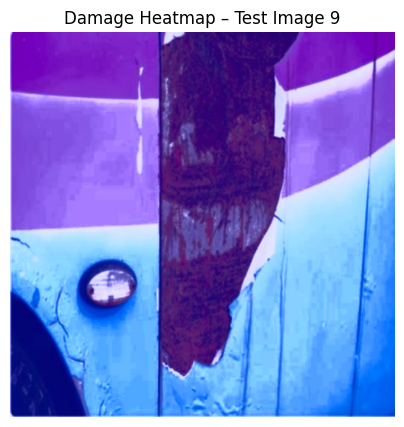

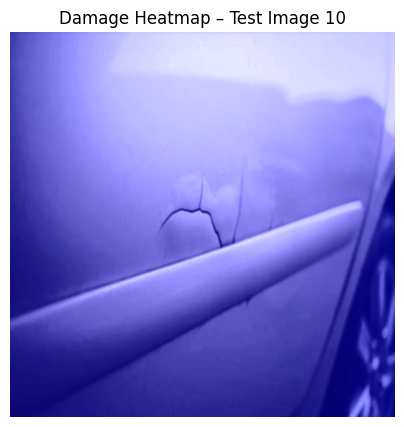

In [79]:
# Generate reports (reuse function we created earlier)
report_9, _ = generate_final_report_for_image(test_img_9, vehicle_type="4W")
report_10, _ = generate_final_report_for_image(test_img_10, vehicle_type="4W")

# Show heatmaps
show_damage_heatmap(test_img_9, report_9, title="Damage Heatmap – Test Image 9")
show_damage_heatmap(test_img_10, report_10, title="Damage Heatmap – Test Image 10")


In [4]:
from collections import Counter

# For Test Image 9
severity_count_9 = Counter([x["severity"] for x in report_9])
damage_type_count_9 = Counter([x["damage_type"] for x in report_9])

print("Image 9 – Severity Distribution:", severity_count_9)
print("Image 9 – Damage Type Distribution:", damage_type_count_9)

# For Test Image 10
severity_count_10 = Counter([x["severity"] for x in report_10])
damage_type_count_10 = Counter([x["damage_type"] for x in report_10])

print("\nImage 10 – Severity Distribution:", severity_count_10)
print("Image 10 – Damage Type Distribution:", damage_type_count_10)


NameError: name 'report_9' is not defined

In [6]:
!pip install pandas

In [7]:
import pandas as pd

df9 = pd.DataFrame(report_9)
df10 = pd.DataFrame(report_10)

print("Image 9 Summary")
display(df9[["damage_type", "severity", "category", "confidence"]])

print("Image 10 Summary")
display(df10[["damage_type", "severity", "category", "confidence"]])


ModuleNotFoundError: No module named 'pandas'